## Predicting Passengers' Data Using Stacked GRU with One Hidden Layer

In [25]:
"""
Dataset is from: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
International Airline Passengers data is to be predicted.
Given a year and a month, the task is to predict the number of international airline passengers per 1,000. 
The data is from January 1949 to December 1960 (12 years, with 144 observations).
"""

'\nDataset is from: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv\nInternational Airline Passengers data is to be predicted.\nGiven a year and a month, the task is to predict the number of international airline passengers per 1,000. \nThe data is from January 1949 to December 1960 (12 years, with 144 observations).\n'

In [12]:
import numpy
numpy.version.version

#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [13]:
#The code only ran when i downgraded to numpy 1.19.2, using 1.20.2 gave a datatype error when passing through the LSTM
numpy.version.version
#pip install numpy 1.19.2

'1.19.2'

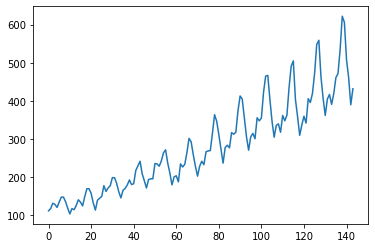

In [14]:
#pd.read_csv('c:\Users\asus\Desktop\airline-passengers.csv')

#load the dataset + using only column number 1
dataframe = read_csv(r"c:\Users\asus\Desktop\airline-passengers.csv", usecols=[1])
plt.plot(dataframe)

#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #Convert values to float

In [15]:
#Normalizing the dataset since the activation functions sigmoid and tanh are sensitive to magnitude
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

#Splitting the data into trainig and testing sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(test_size)
print(train_size)

44
100


In [16]:
#Since we are dealing with a single sequence of data, we need to rearrange our X and Y vectors
#this creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

seq_size = 7  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.



trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


print(trainX.shape[1])
#print(trainX)

Shape of training set: (92, 7)
Shape of test set: (36, 7)
7


In [17]:


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [19]:


#Reshape input to be [samples, time steps, features]
#Stacked LSTM with 1 hidden dense layer
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(GRU(50, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()
print('Train...')




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 50)          8850      
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 25,815
Trainable params: 25,815
Non-trainable params: 0
_________________________________________________________________
Train...


In [20]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions back to prescaled values
#This is to compare with original input values
#Since we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Epoch 1/100
3/3 - 0s - loss: 0.0636 - accuracy: 0.0109 - val_loss: 0.3175 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 - 0s - loss: 0.0433 - accuracy: 0.0109 - val_loss: 0.2398 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 - 0s - loss: 0.0265 - accuracy: 0.0109 - val_loss: 0.1694 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 - 0s - loss: 0.0165 - accuracy: 0.0109 - val_loss: 0.1089 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 - 0s - loss: 0.0112 - accuracy: 0.0109 - val_loss: 0.0652 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 - 0s - loss: 0.0112 - accuracy: 0.0109 - val_loss: 0.0433 - val_accuracy: 0.0278
Epoch 7/100
3/3 - 0s - loss: 0.0135 - accuracy: 0.0109 - val_loss: 0.0372 - val_accuracy: 0.0278
Epoch 8/100
3/3 - 0s - loss: 0.0132 - accuracy: 0.0109 - val_loss: 0.0409 - val_accuracy: 0.0278
Epoch 9/100
3/3 - 0s - loss: 0.0112 - accuracy: 0.0109 - val_loss: 0.0517 - val_accuracy: 0.0000e+00
Epoch 10/100
3/3 - 0s - loss: 0.0096 - accuracy: 0.0109 - val_loss: 0.0639 - val_accuracy: 0.0000e+00
E

Epoch 85/100
3/3 - 0s - loss: 0.0019 - accuracy: 0.0109 - val_loss: 0.0084 - val_accuracy: 0.0278
Epoch 86/100
3/3 - 0s - loss: 0.0019 - accuracy: 0.0109 - val_loss: 0.0087 - val_accuracy: 0.0278
Epoch 87/100
3/3 - 0s - loss: 0.0019 - accuracy: 0.0109 - val_loss: 0.0086 - val_accuracy: 0.0278
Epoch 88/100
3/3 - 0s - loss: 0.0020 - accuracy: 0.0109 - val_loss: 0.0083 - val_accuracy: 0.0278
Epoch 89/100
3/3 - 0s - loss: 0.0020 - accuracy: 0.0109 - val_loss: 0.0090 - val_accuracy: 0.0278
Epoch 90/100
3/3 - 0s - loss: 0.0019 - accuracy: 0.0109 - val_loss: 0.0082 - val_accuracy: 0.0278
Epoch 91/100
3/3 - 0s - loss: 0.0020 - accuracy: 0.0109 - val_loss: 0.0082 - val_accuracy: 0.0278
Epoch 92/100
3/3 - 0s - loss: 0.0020 - accuracy: 0.0109 - val_loss: 0.0096 - val_accuracy: 0.0278
Epoch 93/100
3/3 - 0s - loss: 0.0019 - accuracy: 0.0109 - val_loss: 0.0081 - val_accuracy: 0.0278
Epoch 94/100
3/3 - 0s - loss: 0.0019 - accuracy: 0.0109 - val_loss: 0.0080 - val_accuracy: 0.0278
Epoch 95/100
3/3 - 0

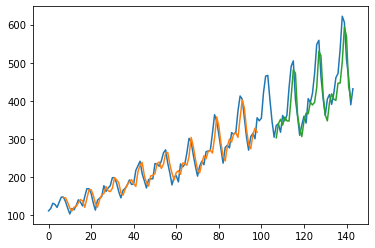

In [24]:
#x-axes must be aligned for the predictions
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

#plotting
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()